<a href="https://colab.research.google.com/github/irisxiu666/ML6410_Final_Project/blob/main/ML_FinalProject_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Passenger Satisfaction

CS6140 - Group 5


Chenyang Zhou, Tingting Xiu

## Import Library and Tool

In [ ]:
pip install scikit-plot

In [ ]:
!pip3 install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot
import scipy.stats as stats
import os
import warnings

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
%matplotlib inline

## Read Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

In [ ]:
print("shape of the train dataset:", train.shape)
print("shape of the test dataset:", test.shape)

shape of the train dataset: (103904, 25)
shape of the test dataset: (25976, 25)


In [ ]:
train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [ ]:
test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


## Helper Function

In [ ]:
def plot_countplots(data, columns, rows, cols, figsize=(15, 15), hue=None, palette='winter'):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        sns.countplot(x=column, data=data, hue=hue, palette=palette, ax=axes[i])

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_numeric_distribution(df):
    numerical = df.select_dtypes(exclude='object')
    n = len(numerical)

    for col in numerical:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 2))
        plt.suptitle(f"Distribution of {col}")
        sns.boxplot(data=df, x=col, ax=ax1, palette="Blues")
        ax1.set_xlabel(None)
        ax1.get_xaxis().set_ticks([])
        sns.histplot(data=df, x=col, ax=ax2, palette="Blues")
        plt.subplots_adjust(hspace=0)
        plt.show()

## Data Preprocessing

### Drop unimportant columns from the train dataset

In [ ]:
column_to_drop = ['Unnamed: 0', 'id','Gender',]
train = train.drop(column_to_drop, axis=1)
test = test.drop(column_to_drop, axis=1)

In [ ]:
selected_columns = ['Seat comfort',
                    'Class',
                    'Inflight wifi service',
                    'Departure/Arrival time convenient',
                    'On-board service',
                    'Ease of Online booking',
                    'Food and drink',
                    'Inflight service',
                    'Cleanliness']

train = train[train[selected_columns].isin([0]).sum(axis=1) == 0]
test = test[test[selected_columns].isin([0]).sum(axis=1) == 0]

In [ ]:
print("shape of train dataframe after dropping:", train.shape)
print("shape of test dataframe after dropping:", test.shape)

shape of train dataframe after dropping: (95715, 22)
shape of test dataframe after dropping: (23866, 22)


In [ ]:
train.head()

,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [ ]:
test.head()

,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,...,4,4,4,4,3,4,5,0,0.0,satisfied
4,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied
5,Loyal Customer,16,Business travel,Eco,311,3,3,3,3,5,...,5,4,3,1,1,2,5,0,0.0,satisfied
6,Loyal Customer,77,Business travel,Business,3987,5,5,5,5,3,...,5,5,5,5,4,5,3,0,0.0,satisfied


### Dataset Overview

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,95715.0,39.810949,15.026307,7.0,28.0,40.0,51.0,85.0
Flight Distance,95715.0,1222.460555,999.416568,31.0,438.0,867.0,1773.0,4983.0
Inflight wifi service,95715.0,2.818806,1.252769,1.0,2.0,3.0,4.0,5.0
Departure/Arrival time convenient,95715.0,3.208139,1.385982,1.0,2.0,3.0,4.0,5.0
Ease of Online booking,95715.0,2.878159,1.296976,1.0,2.0,3.0,4.0,5.0
Gate location,95715.0,2.985478,1.281265,1.0,2.0,3.0,4.0,5.0
Food and drink,95715.0,3.212297,1.323818,1.0,2.0,3.0,4.0,5.0
Online boarding,95715.0,3.326511,1.263430,0.0,2.0,4.0,4.0,5.0
Seat comfort,95715.0,3.454631,1.311351,1.0,2.0,4.0,5.0,5.0
Inflight entertainment,95715.0,3.381487,1.325664,1.0,2.0,4.0,4.0,5.0


In [ ]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,23866.0,40.037836,15.046142,7.0,28.0,41.0,52.00,85.0
Flight Distance,23866.0,1229.616945,1000.794825,31.0,446.0,874.0,1796.75,4983.0
Inflight wifi service,23866.0,2.815637,1.257182,1.0,2.0,3.0,4.00,5.0
Departure/Arrival time convenient,23866.0,3.202548,1.390773,1.0,2.0,3.0,4.00,5.0
Ease of Online booking,23866.0,2.884354,1.306446,1.0,2.0,3.0,4.00,5.0
Gate location,23866.0,2.992625,1.285297,1.0,2.0,3.0,4.00,5.0
Food and drink,23866.0,3.219811,1.326973,1.0,2.0,3.0,4.00,5.0
Online boarding,23866.0,3.344800,1.263944,0.0,2.0,4.0,4.00,5.0
Seat comfort,23866.0,3.462625,1.313393,1.0,2.0,4.0,5.00,5.0
Inflight entertainment,23866.0,3.376100,1.333262,1.0,2.0,4.0,4.00,5.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95715 entries, 0 to 103903
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer Type                      95715 non-null  object 
 1   Age                                95715 non-null  int64  
 2   Type of Travel                     95715 non-null  object 
 3   Class                              95715 non-null  object 
 4   Flight Distance                    95715 non-null  int64  
 5   Inflight wifi service              95715 non-null  int64  
 6   Departure/Arrival time convenient  95715 non-null  int64  
 7   Ease of Online booking             95715 non-null  int64  
 8   Gate location                      95715 non-null  int64  
 9   Food and drink                     95715 non-null  int64  
 10  Online boarding                    95715 non-null  int64  
 11  Seat comfort                       95715 non-null  in

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23866 entries, 0 to 25975
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer Type                      23866 non-null  object 
 1   Age                                23866 non-null  int64  
 2   Type of Travel                     23866 non-null  object 
 3   Class                              23866 non-null  object 
 4   Flight Distance                    23866 non-null  int64  
 5   Inflight wifi service              23866 non-null  int64  
 6   Departure/Arrival time convenient  23866 non-null  int64  
 7   Ease of Online booking             23866 non-null  int64  
 8   Gate location                      23866 non-null  int64  
 9   Food and drink                     23866 non-null  int64  
 10  Online boarding                    23866 non-null  int64  
 11  Seat comfort                       23866 non-null  int

In [ ]:
train.isna().sum()

Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             289
satisfaction                           0
dtype: int64

In [ ]:
test.isna().sum()

Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             74
satisfaction                          0
dtype: int64

### Handle the Missing Value
We can find some null values in column <Departure Delay in Minutes>, then we fill them with the mean value.

In [ ]:
train["Arrival Delay in Minutes"].fillna(train['Arrival Delay in Minutes'].mean(), inplace=True)
test["Arrival Delay in Minutes"].fillna(test['Arrival Delay in Minutes'].mean(), inplace=True)

In [ ]:
train.isna().sum()

Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [ ]:
test.isna().sum()

Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

## Data Exploration

### Data Visualization

Data Distribution

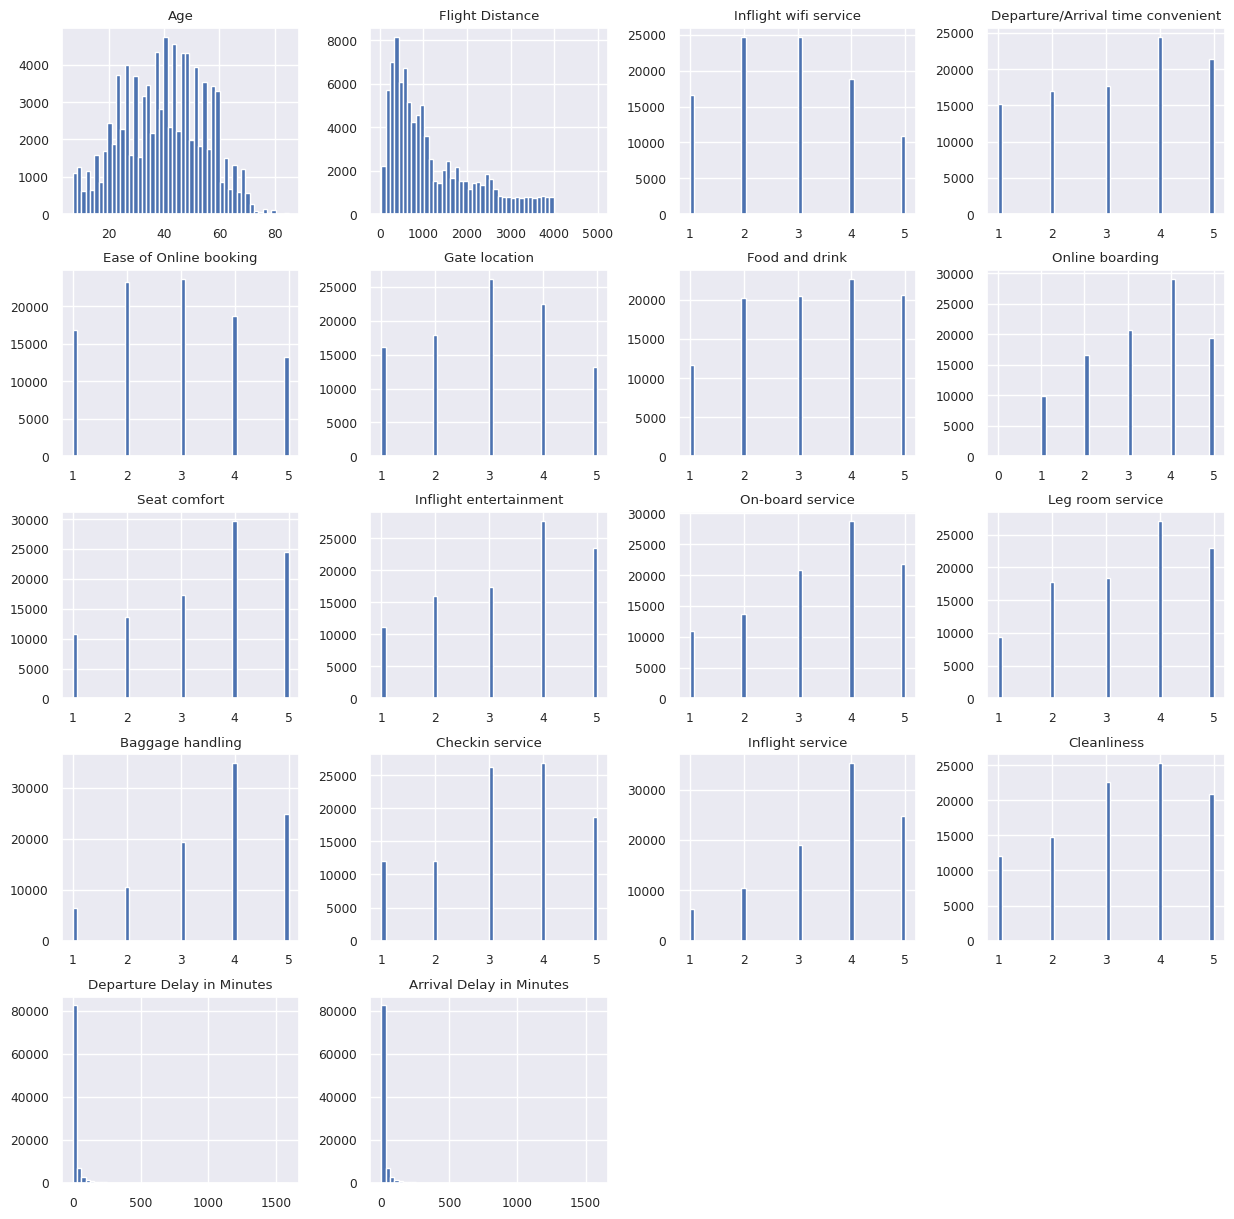

In [ ]:
train.hist(bins=50, figsize=(15,15))
plt.show()

Correlation Matrix

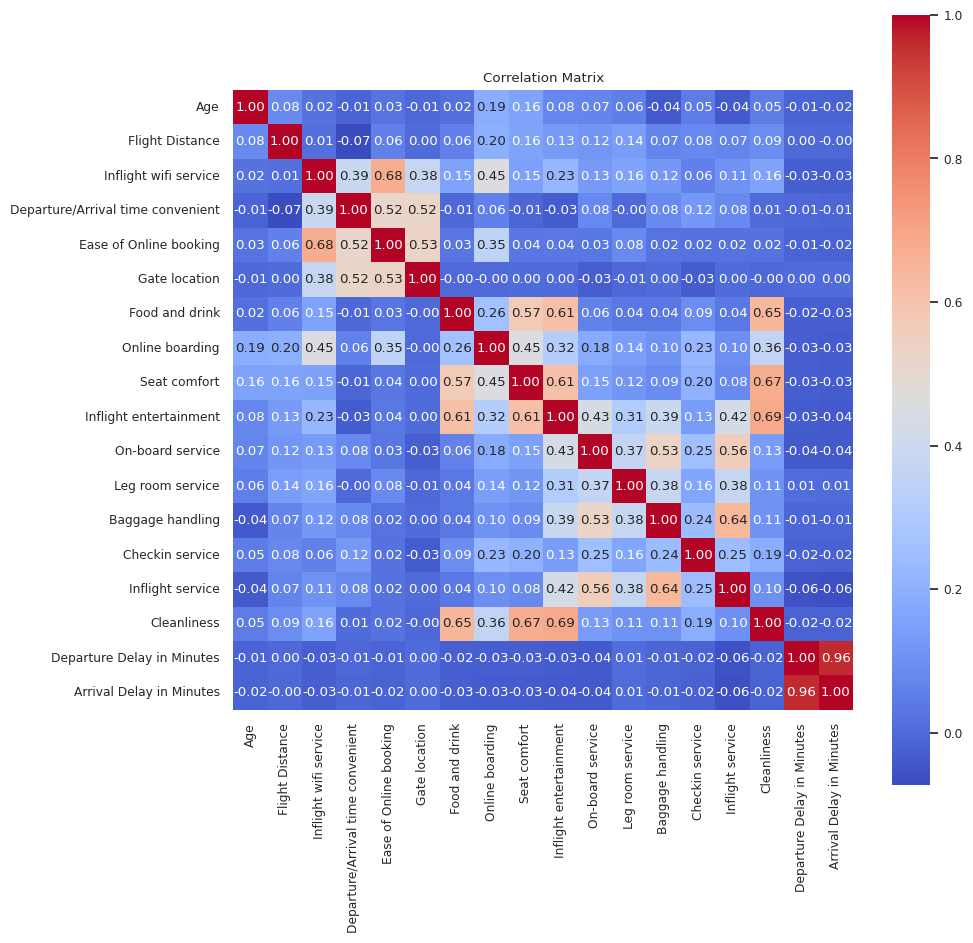

In [ ]:
corr_matrix = train.corr()

plt.figure(figsize=(10, 10))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

plt.title("Correlation Matrix")
plt.show()

In [ ]:
high_correlation_columns_to_drop = ['Departure/Arrival time convenient',
                                    'Gate location',
                                    'Inflight wifi service',
                                    'Baggage handling',
                                    'Seat comfort',
                                    'Food and drink',
                                    'Cleanliness',
                                    'On-board service',
                                    'Departure Delay in Minutes']
#train.drop('Departure Delay in Minutes', axis=1, inplace= True)
#test.drop('Departure Delay in Minutes', axis=1, inplace= True)

train = train.drop(high_correlation_columns_to_drop, axis=1)
test = test.drop(high_correlation_columns_to_drop, axis=1)

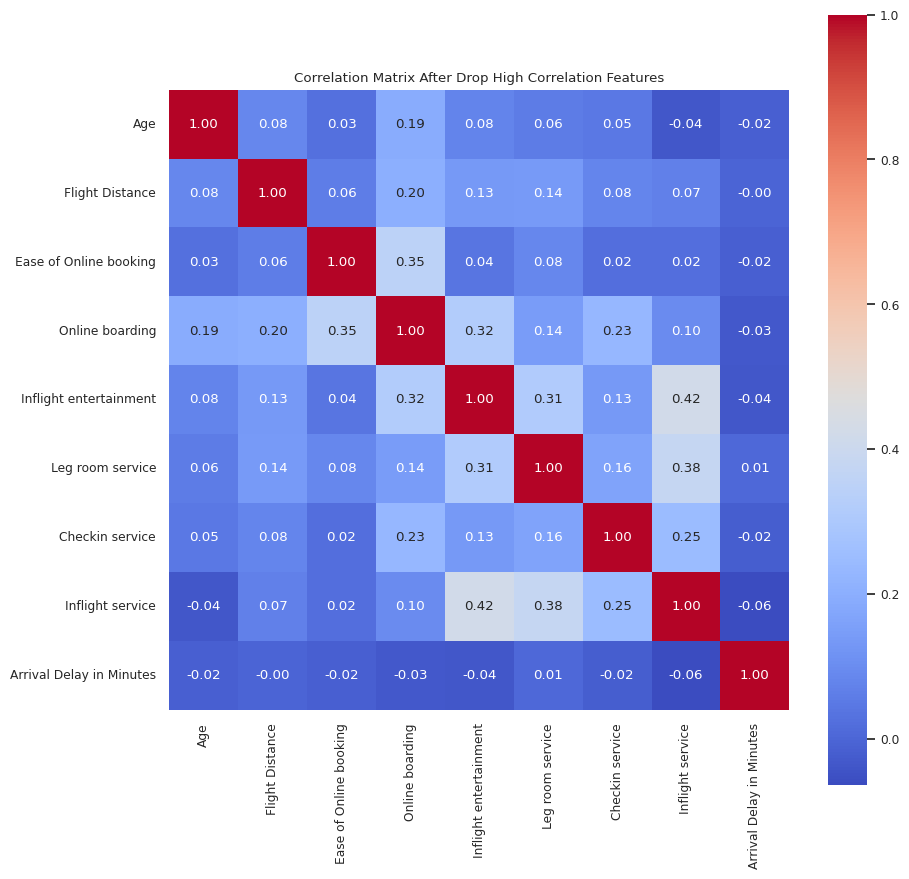

In [ ]:
corr_matrix_2 = train.corr()

plt.figure(figsize=(10, 10))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm', fmt=".2f", square=True)

plt.title("Correlation Matrix After Drop High Correlation Features")
plt.show()

Count Plots

In [ ]:
#columns = ['Customer Type', 'Type of Travel', 'Class', 'Ease of Online booking', 'Inflight service']

In [ ]:
#plot_countplots(train, columns, 3, 4, hue='satisfaction')

Distribution

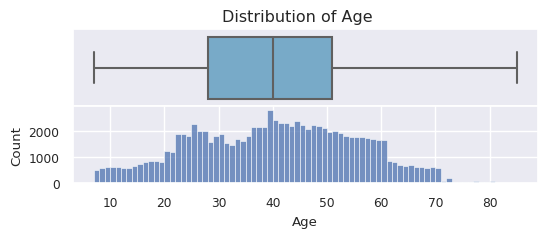

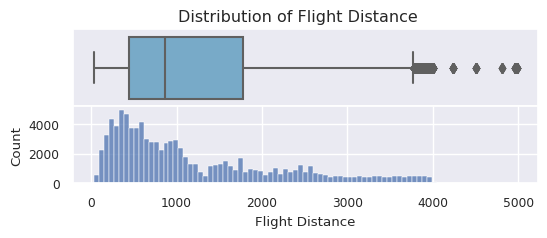

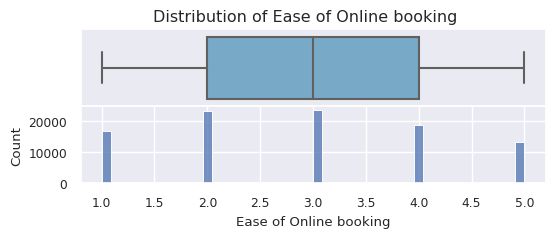

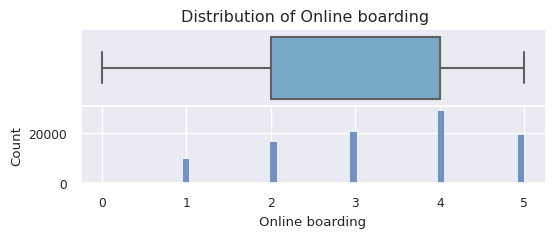

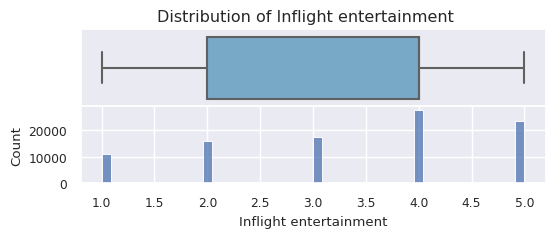

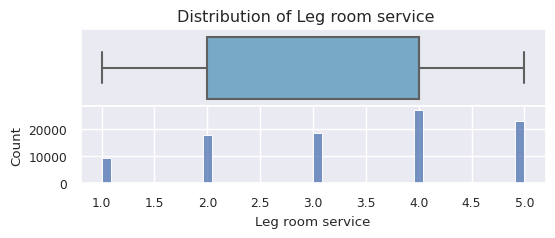

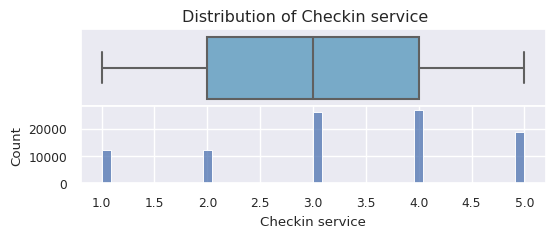

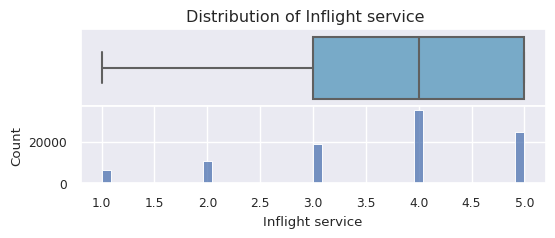

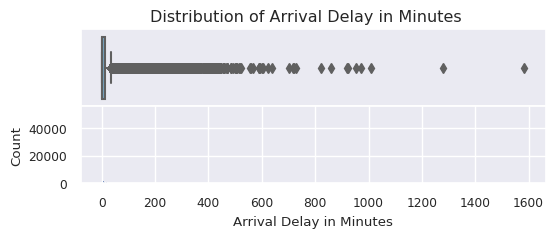

In [ ]:
plot_numeric_distribution(train)

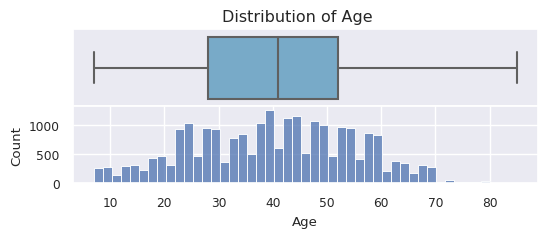

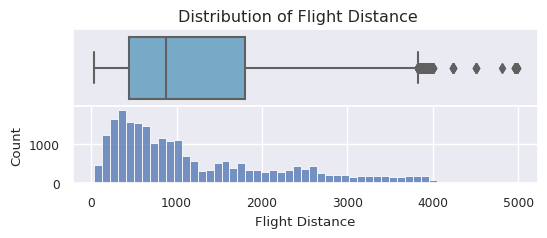

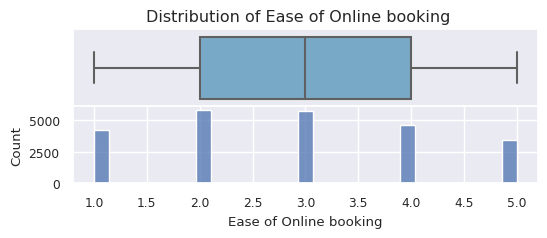

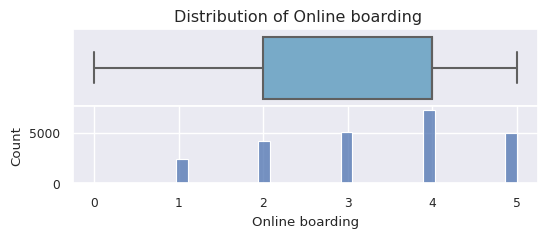

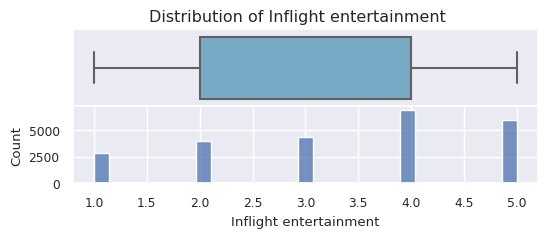

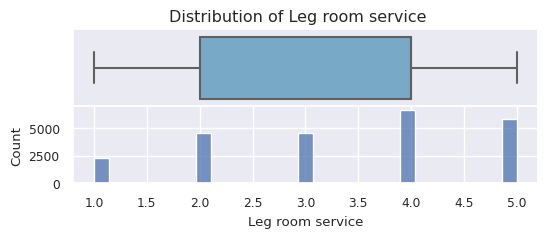

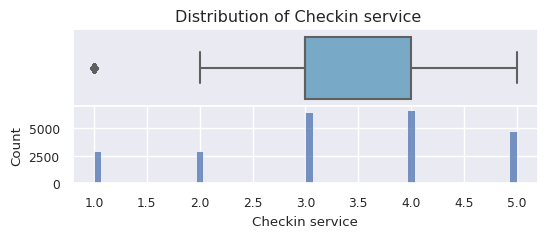

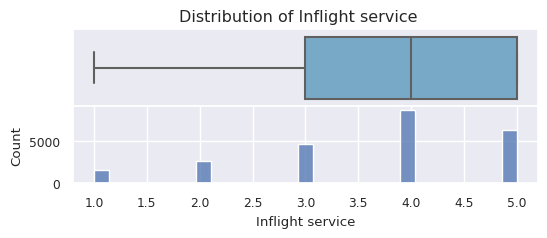

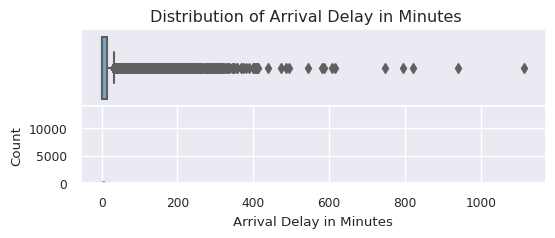

In [ ]:
plot_numeric_distribution(test)

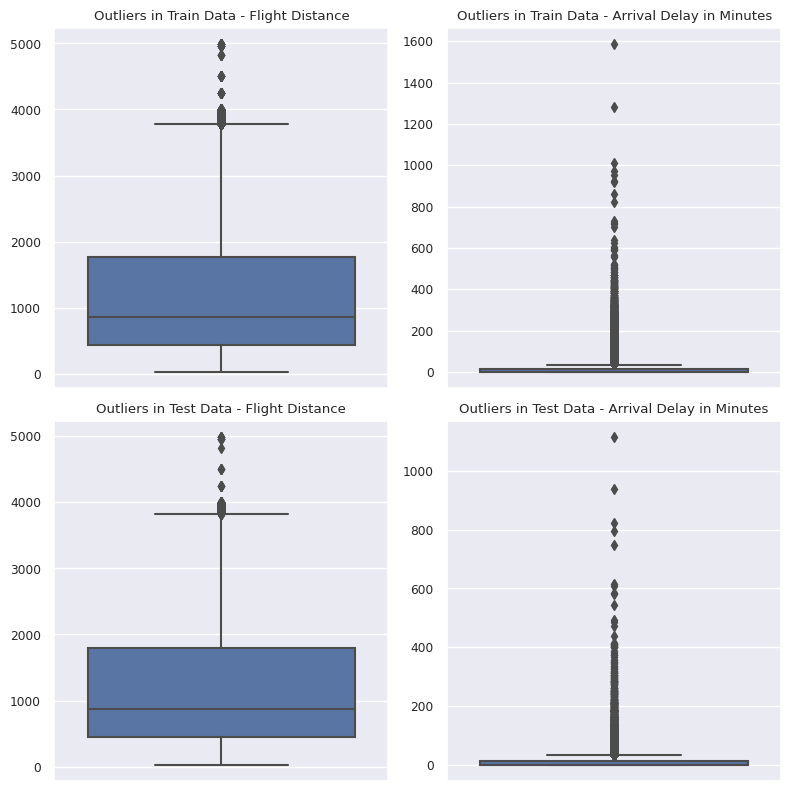

In [ ]:
selected_columns_outliers = ['Flight Distance', 'Arrival Delay in Minutes']

fig, axes = plt.subplots(2, len(selected_columns_outliers), figsize=(8, 8))

for i, column in enumerate(selected_columns_outliers):
    sns.boxplot(data=train[column], ax=axes[0, i])
    axes[0, i].set_title(f'Outliers in Train Data - {column}')
    axes[0, i].get_xaxis().set_visible(False)

for i, column in enumerate(selected_columns_outliers):
    sns.boxplot(data=test[column], ax=axes[1, i])
    axes[1, i].set_title(f'Outliers in Test Data - {column}')
    axes[1, i].get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()

## Data Transformation, spliting, and scaling

In [ ]:
train['satisfaction'] = train['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 2})
#train['Gender'] = train['Gender'].replace({'Female': 0, 'Male': 1})
train['Customer Type'] = train['Customer Type'].replace({'Loyal Customer': 0, 'disloyal Customer': 1})
train['Type of Travel'] = train['Type of Travel'].replace({'Personal Travel':0, 'Business travel':1})
train['Class'] = train['Class'].replace({'Business': 2, 'Eco': 1,'Eco Plus':0})

columns_train = [train['satisfaction'].value_counts(), train['Customer Type'].value_counts(), train['Type of Travel'].value_counts(), train['Class'].value_counts()]
value_counts_train = pd.DataFrame(columns_train)
print(value_counts_train)

                      0        2        1
satisfaction    54948.0  40767.0      NaN
Customer Type   80319.0      NaN  15396.0
Type of Travel  29598.0      NaN  66117.0
Class            6999.0  46470.0  42246.0


In [ ]:
train_to_cluster = train.loc[train['satisfaction'] == 0]
train_to_cluster.head()
# train_to_cluster.isna().sum()
kmeans_model = KMeans(n_clusters=2)
kmeans_model.fit(train_to_cluster)
train_to_cluster['satisfaction'] = kmeans_model.labels_

satisifed_train = train.loc[train['satisfaction'] == 2]
satisifed_train.head()
# merged clustered train and satisifed_train
# train = pd.concat([train_to_cluster, satisifed_train], join="inner")
# train.head()

,Customer Type,Age,Type of Travel,Class,Flight Distance,Ease of Online booking,Online boarding,Inflight entertainment,Leg room service,Checkin service,Inflight service,Arrival Delay in Minutes,satisfaction
2,0,26,1,2,1142,2,5,5,3,4,4,0.0,2
4,0,61,1,2,214,3,5,3,4,3,3,0.0,2
7,0,52,1,2,2035,4,5,5,5,4,5,0.0,2
13,0,33,0,1,946,4,4,4,5,2,2,0.0,2
16,0,26,1,2,2123,3,4,4,3,5,4,51.0,2


In [ ]:
train = pd.concat([train_to_cluster, satisifed_train], join="inner")
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95715 entries, 0 to 103900
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer Type             95715 non-null  int64  
 1   Age                       95715 non-null  int64  
 2   Type of Travel            95715 non-null  int64  
 3   Class                     95715 non-null  int64  
 4   Flight Distance           95715 non-null  int64  
 5   Ease of Online booking    95715 non-null  int64  
 6   Online boarding           95715 non-null  int64  
 7   Inflight entertainment    95715 non-null  int64  
 8   Leg room service          95715 non-null  int64  
 9   Checkin service           95715 non-null  int64  
 10  Inflight service          95715 non-null  int64  
 11  Arrival Delay in Minutes  95715 non-null  float64
 12  satisfaction              95715 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 10.2 MB


In [ ]:
test['satisfaction'] = test['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 2})
#test['Gender'] = test['Gender'].replace({'Female': 0, 'Male': 1})
test['Customer Type'] = test['Customer Type'].replace({'Loyal Customer': 0, 'disloyal Customer': 1})
test['Type of Travel'] = test['Type of Travel'].replace({'Personal Travel':0, 'Business travel':1})
test['Class'] = test['Class'].replace({'Business': 2, 'Eco': 1,'Eco Plus':0})

columns_test = [test['satisfaction'].value_counts(), test['Customer Type'].value_counts(), test['Type of Travel'].value_counts(), test['Class'].value_counts()]
value_counts_test = pd.DataFrame(columns_test)
print(value_counts_test)

                      0        2        1
satisfaction    13590.0  10276.0      NaN
Customer Type   20014.0      NaN   3852.0
Type of Travel   7293.0      NaN  16573.0
Class            1780.0  11695.0  10391.0


In [ ]:
test_to_cluster = test.loc[test['satisfaction'] == 0]

kmeans_model = KMeans(n_clusters=2)
kmeans_model.fit(test_to_cluster)
test_to_cluster['satisfaction'] = kmeans_model.labels_

satisifed_test = train.loc[train['satisfaction'] == 2]
# merged clustered train and satisifed_train
test = pd.concat([test_to_cluster, satisifed_test], join="inner")
test.head()

,Customer Type,Age,Type of Travel,Class,Flight Distance,Ease of Online booking,Online boarding,Inflight entertainment,Leg room service,Checkin service,Inflight service,Arrival Delay in Minutes,satisfaction
11,0,33,1,2,325,5,3,2,2,3,2,7.0,0
16,0,31,1,1,728,5,2,2,3,4,3,0.0,0
18,0,43,0,1,1927,3,4,5,3,4,5,0.0,1
21,0,43,0,1,1437,3,3,2,2,4,5,0.0,0
22,0,55,0,1,302,4,4,4,3,4,3,0.0,0


In [ ]:
columns_test = [test['satisfaction'].value_counts()]
value_counts_test = pd.DataFrame(columns_test)
print(value_counts_test)

                  2      0     1
satisfaction  40767  11081  2509


In [ ]:
columns_train = [train['satisfaction'].value_counts()]
value_counts_train = pd.DataFrame(columns_train)
print(value_counts_train)

                  0      2      1
satisfaction  44283  40767  10665


In [ ]:
test.head()

,Customer Type,Age,Type of Travel,Class,Flight Distance,Ease of Online booking,Online boarding,Inflight entertainment,Leg room service,Checkin service,Inflight service,Arrival Delay in Minutes,satisfaction
11,0,33,1,2,325,5,3,2,2,3,2,7.0,0
16,0,31,1,1,728,5,2,2,3,4,3,0.0,0
18,0,43,0,1,1927,3,4,5,3,4,5,0.0,1
21,0,43,0,1,1437,3,3,2,2,4,5,0.0,0
22,0,55,0,1,302,4,4,4,3,4,3,0.0,0


In [ ]:
X_train = train.drop(columns=['satisfaction'])
y_train = train['satisfaction']

X_test = test.drop(columns=['satisfaction'])
y_test = test['satisfaction']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
scaler = RobustScaler()

X_train_unscaled = X_train
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (76572, 12)
X_test: (19143, 12)
y_train: (76572,)
y_test: (19143,)


In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# imbalance data
ROS = RandomOverSampler(random_state=42)

X_train, y_train = ROS.fit_resample(X_train, y_train)

print("Updata dataset Train: ", Counter(y_train))

Updata dataset Train:  Counter({0: 35309, 2: 35309, 1: 35309})


## Modeling

### KNN Classification

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred_knn = knn.predict(X_test)

In [ ]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy: ", round(accuracy_knn * 100, 2), "%")

KNN Accuracy:  88.06 %


In [ ]:
knn_report = classification_report(y_test, y_pred_knn)
print(knn_report)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      8974
           1       0.65      0.87      0.74      2095
           2       0.92      0.86      0.89      8074

    accuracy                           0.88     19143
   macro avg       0.83      0.88      0.85     19143
weighted avg       0.89      0.88      0.88     19143



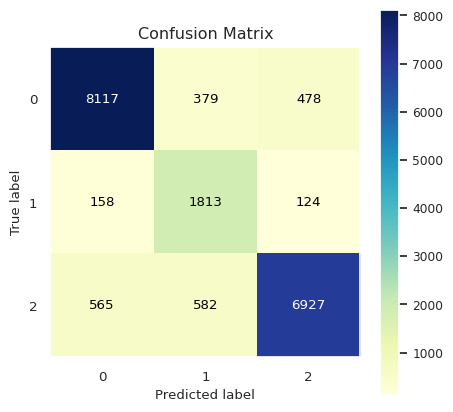

In [ ]:
cm_knn = scikitplot.metrics.plot_confusion_matrix(y_test, y_pred_knn, figsize=(5,5), cmap= 'YlGnBu');

In [ ]:
# roc_knn = RocCurveDisplay.from_estimator(knn, X_test, y_test)
# plt.show()

ValueError: ignored

### Random Forest Classification

Tuned Random Forest Parameters

In [ ]:
rf = RandomForestClassifier()

param_dist = {'n_estimators': [50, 100, 150, 200, 250],
              'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'criterion': ['gini', 'entropy']}

# Randomized search over the hyperparameter space to find the best set of hyperparameters
rf_cv = RandomizedSearchCV(rf,
                           param_distributions=param_dist,
                           cv=5,
                           random_state=42,
                           n_jobs=-1,
                           verbose=1,
                           n_iter=10)
rf_cv.fit(X_train, y_train)
best_parameters = rf_cv.best_params_

print('Tuned Random Forest Parameters:\n %s' % (best_parameters))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned Random Forest Parameters:
 {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': 10, 'criterion': 'gini'}


Random Forest Classifier with the best parameters

In [ ]:
rfc = RandomForestClassifier(n_estimators=100,
                             min_samples_split=8,
                             min_samples_leaf=1,
                             max_features=9,
                             max_depth=10,
                             criterion='gini')

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=9, min_samples_split=8)

In [ ]:
y_pred_rfc = rfc.predict(X_test)

In [ ]:
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print("Ramdom Forest Accuracy: ", round(accuracy_rfc * 100, 2), "%")

Ramdom Forest Accuracy:  92.55 %


In [ ]:
rfc_report = classification_report(y_test, y_pred_rfc)
print(rfc_report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8974
           1       0.82      0.97      0.89      2095
           2       0.93      0.89      0.91      8074

    accuracy                           0.93     19143
   macro avg       0.90      0.94      0.92     19143
weighted avg       0.93      0.93      0.93     19143



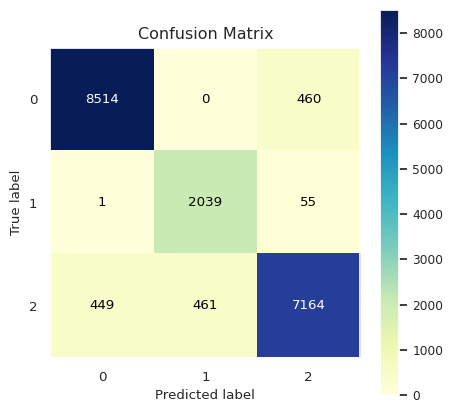

In [ ]:
cm_rfc = scikitplot.metrics.plot_confusion_matrix(y_test, y_pred_rfc, figsize=(5,5), cmap= 'YlGnBu');

In [ ]:
# roc_rfc = RocCurveDisplay.from_estimator(rfc, X_test, y_test)
# plt.show()

ValueError: ignored

### CatBoost Classification

In [ ]:
cb = CatBoostClassifier()
cb.fit(X_train, y_train)

Learning rate set to 0.100369
0:	learn: 0.9541307	total: 168ms	remaining: 2m 47s
1:	learn: 0.8457496	total: 311ms	remaining: 2m 35s
2:	learn: 0.7592088	total: 455ms	remaining: 2m 31s
3:	learn: 0.6898470	total: 635ms	remaining: 2m 38s
4:	learn: 0.6308714	total: 797ms	remaining: 2m 38s
5:	learn: 0.5816436	total: 892ms	remaining: 2m 27s
6:	learn: 0.5384615	total: 984ms	remaining: 2m 19s
7:	learn: 0.5018233	total: 1.15s	remaining: 2m 22s
8:	learn: 0.4698682	total: 1.3s	remaining: 2m 23s
9:	learn: 0.4401301	total: 1.43s	remaining: 2m 21s
10:	learn: 0.4160497	total: 1.56s	remaining: 2m 20s
11:	learn: 0.3942763	total: 1.71s	remaining: 2m 21s
12:	learn: 0.3746506	total: 1.88s	remaining: 2m 22s
13:	learn: 0.3568389	total: 2.05s	remaining: 2m 24s
14:	learn: 0.3415616	total: 2.15s	remaining: 2m 21s
15:	learn: 0.3266356	total: 2.28s	remaining: 2m 20s
16:	learn: 0.3137364	total: 2.41s	remaining: 2m 19s
17:	learn: 0.3019027	total: 2.54s	remaining: 2m 18s
18:	learn: 0.2921911	total: 2.7s	remaining: 2

In [ ]:
y_pred_cb = cb.predict(X_test)

In [ ]:
accuracy_cb = accuracy_score(y_test, y_pred_cb)
print("CatBoost Accuracy: ", round(accuracy_cb * 100, 2), "%")

CatBoost Accuracy:  93.11 %


In [ ]:
cb_report = classification_report(y_test, y_pred_cb)
print(cb_report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      8974
           1       0.84      0.97      0.90      2095
           2       0.94      0.89      0.92      8074

    accuracy                           0.93     19143
   macro avg       0.91      0.94      0.92     19143
weighted avg       0.93      0.93      0.93     19143



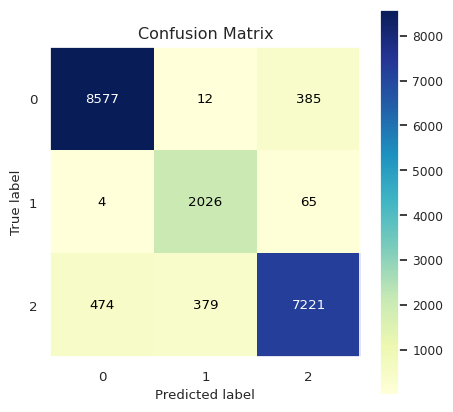

In [ ]:
cm_cb = scikitplot.metrics.plot_confusion_matrix(y_test, y_pred_cb, figsize=(5,5), cmap= 'YlGnBu');

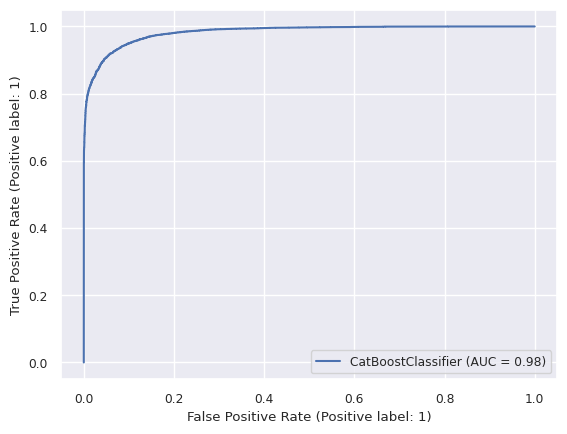

In [ ]:
# roc_cb = RocCurveDisplay.from_estimator(cb, X_test, y_test)
# plt.show()

### XGBoost Classification

In [ ]:
xgb = XGBClassifier(random_state=2)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred_xgb = xgb.predict(X_test)

In [ ]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", round(accuracy_xgb * 100, 2), "%")

XGBoost Accuracy: 93.16 %


In [ ]:
xgb_report = classification_report(y_test, y_pred_xgb)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      8974
           1       0.84      0.96      0.90      2095
           2       0.94      0.90      0.92      8074

    accuracy                           0.93     19143
   macro avg       0.91      0.94      0.92     19143
weighted avg       0.93      0.93      0.93     19143



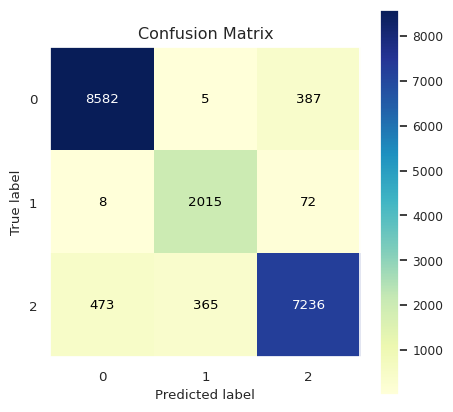

In [ ]:
cm_xgb = scikitplot.metrics.plot_confusion_matrix(y_test, y_pred_xgb, figsize=(5,5), cmap= 'YlGnBu');

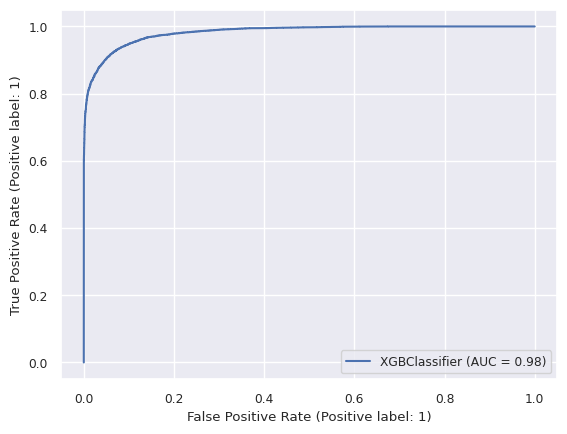

In [ ]:
# roc_xgb = RocCurveDisplay.from_estimator(xgb, X_test, y_test)
# plt.show()

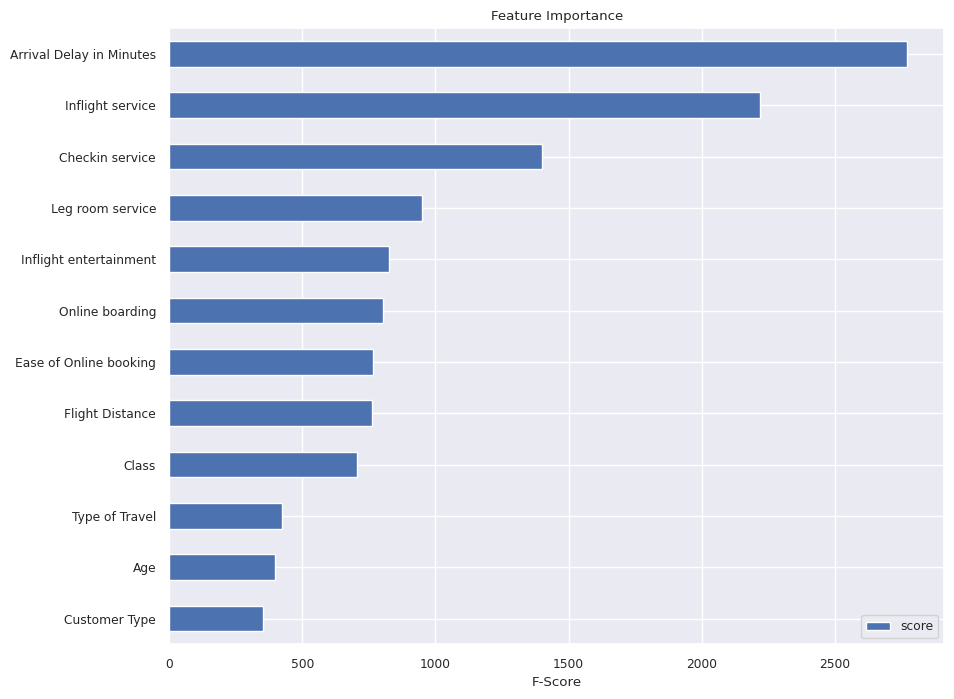

In [ ]:
# how important of each feature influence the satification in XGBoost model
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score")
ax = data.plot(kind='barh', figsize = (10, 8))
ax.set_yticklabels(X_train_unscaled.columns); ## plot top features
ax.set(xlabel="F-Score")
ax.set_title('Feature Importance');

## Results Comparition and Evaluation

Classification Report

In [ ]:
reports = [knn_report, rfc_report, cb_report, xgb_report]
reports_name = ["KNN Classification Report", "Random Forest Classification Report", "CatBoost Classification Report", "XGBoost Classification Report"]

for i in range(len(reports)):
  print(reports_name[i])
  print(reports[i])
  print("*" * 60)

KNN Classification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      8974
           1       0.65      0.87      0.74      2095
           2       0.92      0.86      0.89      8074

    accuracy                           0.88     19143
   macro avg       0.83      0.88      0.85     19143
weighted avg       0.89      0.88      0.88     19143

************************************************************
Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8974
           1       0.82      0.97      0.89      2095
           2       0.93      0.89      0.91      8074

    accuracy                           0.93     19143
   macro avg       0.90      0.94      0.92     19143
weighted avg       0.93      0.93      0.93     19143

************************************************************
CatBoost Classification Report
              precision

ROC Curve

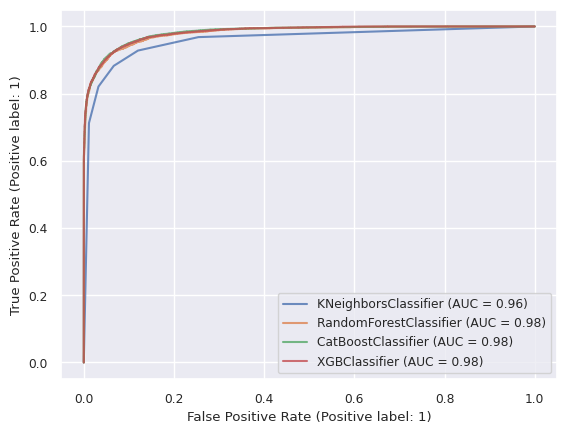

In [ ]:
# ax = plt.gca()
# roc_knn.plot(ax=ax, alpha=0.8)
# roc_rfc.plot(ax=ax, alpha=0.8)
# roc_cb.plot(ax=ax, alpha=0.8)
# roc_xgb.plot(ax=ax, alpha=0.8)
# plt.show()